In [18]:
import quimb.tensor as qtn
import torch
from vmc_torch.fermion_utils import *
L = 10
D = 6

In [19]:
random_mps = qtn.MPS_rand_state(L=L, bond_dim=D, cyclic=False)
random_mps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

In [20]:
ham = qtn.ham_1d_heis(L, j=1.0, cyclic=False)
ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

In [21]:
random_mps.compute_local_expectation_exact(ham.terms, normalized=True)

tensor(0.4702, dtype=torch.float64)

In [22]:
# su = qtn.SimpleUpdateGen(
#     random_mps,
#     ham,
#     D=D,
#     second_order_reflect=True,
#     compute_energy_every=10,
#     compute_energy_fn = lambda su: su.get_state().compute_local_expectation_exact(ham.terms, normalized=True),
#     plot_every=10,
# )

In [23]:
# su.evolve(100, tau=0.1)
# su.evolve(100, tau=0.05)
# su.evolve(100, tau=0.01)

In [24]:
# su.evolve(2000, tau=0.01)

In [25]:
# import pickle
# su.assemble_plot_data()
# with open("circuitTNF_heis_L10_D6_plot.pkl", "wb") as f:
#     pickle.dump(su.assemble_plot_data(), f)
# with open("circuitTNF_heis_L10_D6_su_state.pkl", "wb") as f:
#     params, skeleton = qtn.pack(su.get_state())
#     pickle.dump((params, skeleton), f)

In [26]:
import quimb as qu
qu.groundenergy(qu.ham_heis(L, j=1.0))

np.float64(-4.258035207282882)

In [27]:
from vmc_torch.experiment.tn_model import circuit_TNF
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR, DecayScheduler
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian_torch import spin_Heisenberg_chain_torch
from vmc_torch.torch_utils import SVD,QR

import pickle
su_params, su_skeleton = pickle.load(open("circuitTNF_heis_L10_D6_su_state.pkl", "rb"))
su_mps = qtn.unpack(su_params, su_skeleton)
circuit_tnf = circuit_TNF(
    su_mps,
    ham,
    trotter_tau=0.01,
    depth=4
)


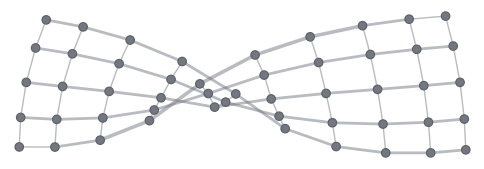

tensor(0.3495, dtype=torch.float64, grad_fn=<MulBackward0>)

In [28]:
state = circuit_tnf.get_state()
config = torch.tensor([0,1,0,1,0,1,0,1,0,1], dtype=torch.int8)
amp = state.get_amp(config)
amp.draw()
amp.contract()

In [29]:
circuit_tnf(config)

tensor([0.3495], dtype=torch.float64, grad_fn=<StackBackward0>)

In [30]:
circuit_tnf.num_params

2600

In [31]:
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR, DecayScheduler
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian_torch import spin_Heisenberg_chain_torch
from vmc_torch.torch_utils import SVD,QR

import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
from mpi4py import MPI
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()



H = spin_Heisenberg_chain_torch(L, J=1.0, pbc=False, total_sz=0)
ham_quimb = qtn.ham_1d_heis(L, j=1.0, cyclic=False)
ham_quimb.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))
graph = H.graph
hilbert = H.hilbert
dtype = torch.float64

import pickle
su_params, su_skeleton = pickle.load(open("circuitTNF_heis_L10_D6_su_state.pkl", "rb"))
su_mps = qtn.unpack(su_params, su_skeleton)

model = circuit_TNF(
    su_mps,
    ham_quimb,
    trotter_tau=0.01,
    depth=4,
    max_bond=-1,
    dtype=torch.float64
)

# VMC sample size
N_samples = int(4)
N_samples = N_samples - N_samples % SIZE + SIZE
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

# Set up optimizer and scheduler
learning_rate = 1e-1
scheduler = DecayScheduler(init_lr=learning_rate, decay_rate=0.9, patience=50, min_lr=1e-4)
optimizer = SGD(learning_rate=learning_rate)
sampler = MetropolisExchangeSamplerSpinless(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=True, dtype=dtype, equal_partition=True)
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# Set up VMC
vmc = VMC(hamiltonian=H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner, scheduler=scheduler)

if __name__ == "__main__":
    energy_dict = variational_state.expect(H)

Burn-in...
Burn-in time: 4.863765623000006


Sampling starts for rank 0...: 100%|██████████| 6/6 [00:32<00:00,  5.50s/it, Time per sample for each rank=5.32]

RANK0, sample size: 6, chain length per rank: 6
Time for MPI communication: 0.0004477449999740202
R_hat: 1.7879752109214078
V_hat:0.004462219648482903, OP_var:0.0031616533643041337


In [32]:
energy_dict

{'mean': np.float64(-4.232411794526872),
 'variance': np.float64(0.0031616533643041337),
 'error': np.float64(0.022955222224670845)}

In [33]:
su_mps.compute_local_expectation_exact(ham.terms, normalized=True)

tensor(-4.2548, dtype=torch.float64)